# Segmentação de Clientes por Comportamento de Compra - Olist

Este notebook realiza uma análise completa de segmentação de clientes da Olist utilizando o algoritmo **K-means**. A abordagem se baseia em uma análise **RFM (Recency, Frequency, Monetary)** expandida, incorporando outras variáveis comportamentais para criar perfis de clientes mais detalhados.

**Pipeline do Projeto:**
1.  **Carregamento e Preparação dos Dados**: Integração de múltiplos datasets da Olist.
2.  **Engenharia de Features**: Criação de variáveis RFM e comportamentais.
3.  **Análise Exploratória**: Visualização da distribuição das features.
4.  **Modelagem com K-means**:
    * Seleção e padronização das variáveis.
    * Determinação do número ótimo de clusters (Elbow Method & Silhouette Score).
    * Treinamento do modelo.
5.  **Análise e Interpretação dos Clusters**:
    * Criação de perfis para cada segmento de cliente.
    * Visualização das características dos clusters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Carregamento e Preparação dos Dados

Nesta seção, carregamos os múltiplos arquivos CSV da Olist e os unimos em um único DataFrame principal (`master_df`), que servirá de base para nossa análise. Apenas pedidos com status "delivered" são considerados.

In [2]:
import pandas as pd
import os

# Lista dos arquivos CSV que você quer converter
csv_files = [
    'olist_customers_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv'
]

print("Iniciando a conversão de CSV para Parquet...")

# Loop para ler cada CSV e salvar como Parquet
for file_name in csv_files:
    if os.path.exists(file_name):
        # Gera o novo nome do arquivo com a extensão .parquet
        parquet_name = file_name.replace('.csv', '.parquet')
        
        # Lê o arquivo CSV
        df = pd.read_csv(file_name)
        
        # Salva no formato Parquet
        df.to_parquet(parquet_name, engine='pyarrow')
        
        print(f"✔️ '{file_name}' convertido para '{parquet_name}'")
    else:
        print(f"⚠️ Arquivo '{file_name}' não encontrado. Pulando.")

print("\nConversão concluída!")

Iniciando a conversão de CSV para Parquet...
✔️ 'olist_customers_dataset.csv' convertido para 'olist_customers_dataset.parquet'
✔️ 'olist_orders_dataset.csv' convertido para 'olist_orders_dataset.parquet'
✔️ 'olist_order_items_dataset.csv' convertido para 'olist_order_items_dataset.parquet'
✔️ 'olist_order_payments_dataset.csv' convertido para 'olist_order_payments_dataset.parquet'
✔️ 'olist_order_reviews_dataset.csv' convertido para 'olist_order_reviews_dataset.parquet'

Conversão concluída!


In [3]:
def load_olist_data():
    """
    Carrega todos os datasets necessários do Olist a partir dos arquivos Parquet.
    """
    try:
        # Modificado para ler arquivos .parquet, que é mais rápido
        customers = pd.read_parquet('olist_customers_dataset.parquet')
        orders = pd.read_parquet('olist_orders_dataset.parquet')
        order_items = pd.read_parquet('olist_order_items_dataset.parquet')
        payments = pd.read_parquet('olist_order_payments_dataset.parquet')
        reviews = pd.read_parquet('olist_order_reviews_dataset.parquet')
        
        print("✅ Datasets (Parquet) carregados com sucesso!")
        return customers, orders, order_items, payments, reviews
    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivo Parquet não encontrado - {e.filename}")
        print("Por favor, execute primeiro a célula de conversão de CSV para Parquet.")
        return None

# O restante da célula 4 (a função prepare_master_dataset) permanece igual.
def prepare_master_dataset(customers, orders, order_items, payments, reviews):
    """
    Cria dataset master integrando todas as tabelas e filtrando por pedidos entregues.
    """
    print("\n🔧 Preparando dataset master...")
    
    # Converter datas
    for col in ['order_purchase_timestamp', 'order_delivered_customer_date']:
        orders[col] = pd.to_datetime(orders[col])
        
    # Junções (Merges)
    master_df = customers.merge(orders, on='customer_id', how='inner')
    
    # Agregação de itens
    order_summary = order_items.groupby('order_id').agg(
        total_price=('price', 'sum'),
        total_freight=('freight_value', 'sum'),
        total_items=('order_item_id', 'count')
    ).reset_index()
    
    # Agregação de pagamentos
    payment_summary = payments.groupby('order_id').agg(
        payment_value=('payment_value', 'sum'),
        avg_installments=('payment_installments', 'mean'),
        preferred_payment_type=('payment_type', lambda x: x.mode()[0] if not x.empty else 'unknown')
    ).reset_index()
    
    # Agregação de reviews
    review_summary = reviews.groupby('order_id').agg(review_score=('review_score', 'mean')).reset_index()
    
    # Merge de todas as partes
    master_df = master_df.merge(order_summary, on='order_id', how='left')
    master_df = master_df.merge(payment_summary, on='order_id', how='left')
    master_df = master_df.merge(review_summary, on='order_id', how='left')
    
    # Filtrar apenas pedidos entregues
    master_df = master_df[master_df['order_status'] == 'delivered'].copy()
    
    print(f"✔️ Dataset master criado com {master_df.shape[0]} registros e {master_df.shape[1]} colunas.")
    return master_df

In [4]:
# Carregar os dados
datasets = load_olist_data()

# Se os dados foram carregados, preparar o dataset master
if datasets:
    customers, orders, order_items, payments, reviews = datasets
    master_df = prepare_master_dataset(customers, orders, order_items, payments, reviews)
    display(master_df.head())

✅ Datasets (Parquet) carregados com sucesso!

🔧 Preparando dataset master...
✔️ Dataset master criado com 96478 registros e 19 colunas.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,total_price,total_freight,total_items,payment_value,avg_installments,preferred_payment_type,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,124.99,21.88,1.0,146.87,2.0,credit_card,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,289.00,46.48,1.0,335.48,8.0,credit_card,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,139.94,17.79,1.0,157.73,7.0,credit_card,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,149.94,23.36,1.0,173.30,1.0,credit_card,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,230.00,22.25,1.0,252.25,8.0,credit_card,5.0


## 2. Engenharia de Features (RFM e Comportamentais)

Aqui, agrupamos os dados por cliente (`customer_unique_id`) para criar as variáveis que descreverão seu comportamento. As principais são:

* **Recency (R)**: Dias desde a última compra.
* **Frequency (F)**: Número total de pedidos.
* **Monetary (M)**: Valor total gasto.

Além do RFM clássico, adicionamos outras features como ticket médio, satisfação média, tempo de vida como cliente e parcelas médias.

In [5]:
# CÉLULA 7 CORRIGIDA

def create_rfm_features(df):
    """
    Cria variáveis RFM e outras variáveis comportamentais a partir do dataset master.
    """
    print("\n💡 Criando features RFM e comportamentais...")
    
    reference_date = df['order_purchase_timestamp'].max()
    
    customer_features = df.groupby('customer_unique_id').agg(
        last_purchase_date=('order_purchase_timestamp', 'max'),
        first_purchase_date=('order_purchase_timestamp', 'min'),
        frequency=('order_id', 'nunique'),
        monetary=('payment_value', 'sum'),
        avg_order_value=('payment_value', 'mean'),
        total_items=('total_items', 'sum'),
        avg_review_score=('review_score', 'mean'),
        avg_installments=('avg_installments', 'mean')
    ).round(2)
    
    # Cálculo das features derivadas
    customer_features['recency'] = (reference_date - customer_features['last_purchase_date']).dt.days
    customer_features['customer_lifetime_days'] = (customer_features['last_purchase_date'] - customer_features['first_purchase_date']).dt.days
    
    # ------------------- INÍCIO DA CORREÇÃO -------------------
    # Tratamento completo de nulos nas features que serão usadas
    customer_features['avg_review_score'].fillna(customer_features['avg_review_score'].mean(), inplace=True)
    
    # Para outras colunas, preencher com 0 faz sentido (ex: sem pagamento, sem parcelas, etc.)
    cols_to_fill_zero = ['monetary', 'avg_order_value', 'total_items', 'avg_installments', 'customer_lifetime_days']
    for col in cols_to_fill_zero:
        customer_features[col].fillna(0, inplace=True)
    # -------------------- FIM DA CORREÇÃO ---------------------
        
    print(f"✔️ Features criadas para {len(customer_features)} clientes únicos.")
    return customer_features

In [6]:
customer_features = create_rfm_features(master_df)
display(customer_features.head())
display(customer_features.describe())


💡 Criando features RFM e comportamentais...
✔️ Features criadas para 93358 clientes únicos.


,last_purchase_date,first_purchase_date,frequency,monetary,avg_order_value,total_items,avg_review_score,avg_installments,recency,customer_lifetime_days
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.90,141.90,1.0,5.0,8.0,111,0
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.19,27.19,1.0,4.0,1.0,114,0
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.22,86.22,1.0,3.0,8.0,536,0
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.62,43.62,1.0,4.0,4.0,320,0
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.89,196.89,1.0,5.0,6.0,287,0


,last_purchase_date,first_purchase_date,frequency,monetary,avg_order_value,total_items,avg_review_score,avg_installments,recency,customer_lifetime_days
count,93358,93358,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,2018-01-04 03:47:36.045363200,2018-01-01 12:18:32.380503296,1.033420,165.197003,160.314931,1.180370,4.153643,2.899733,236.941773,2.634032
min,2016-09-15 12:16:38,2016-09-15 12:16:38,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2017-09-17 18:25:15,2017-09-13 15:41:22.500000,1.000000,63.052500,62.370000,1.000000,4.000000,1.000000,113.000000,0.000000
50%,2018-01-23 00:12:12.500000,2018-01-20 06:48:07,1.000000,107.780000,105.630000,1.000000,5.000000,2.000000,218.000000,0.000000
75%,2018-05-07 17:22:34.750000128,2018-05-05 14:13:38.249999872,1.000000,182.557500,176.650000,1.000000,5.000000,4.000000,345.000000,0.000000
max,2018-08-29 15:00:37,2018-08-29 15:00:37,15.000000,13664.080000,13664.080000,24.000000,5.000000,24.000000,713.000000,633.000000
std,NaN,NaN,0.209097,226.314012,219.571513,0.620857,1.276017,2.675904,152.591453,24.955822


## 3. Análise Exploratória e Preparação para Clustering

Antes de aplicar o K-means, analisamos a distribuição das nossas features. Variáveis com alta assimetria (como *recency*, *frequency* e *monetary*) são comuns nesse tipo de análise.

Para o K-means, é crucial:
1.  **Tratar outliers**: Usamos o método IQR para limitar valores extremos que podem distorcer os centróides.
2.  **Padronizar os dados**: Colocamos todas as features na mesma escala usando `StandardScaler` para que nenhuma variável domine o cálculo de distância.

In [7]:
def analyze_rfm_distribution(df):
    """
    Analisa e visualiza a distribuição das principais variáveis.
    """
    print("\n📊 Analisando a distribuição das variáveis...")
    rfm_cols = ['recency', 'frequency', 'monetary', 'avg_order_value', 'avg_review_score']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(rfm_cols):
        sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribuição de {col}', fontsize=14)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')
    
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

def prepare_clustering_data(df):
    """
    Prepara os dados para o clustering: seleciona features, trata outliers e padroniza.
    """
    print("\n⚙️ Preparando dados para o K-means...")
    
    clustering_features = [
        'recency', 'frequency', 'monetary', 'avg_order_value', 
        'avg_review_score', 'customer_lifetime_days', 'avg_installments'
    ]
    X = df[clustering_features].copy()
    
    # Tratar outliers com método IQR
    for col in X.columns:
        Q1, Q3 = X[col].quantile(0.25), X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        X[col] = np.clip(X[col], lower, upper)
    
    # Padronização
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=X.index)
    
    print("✔️ Dados prontos para o clustering.")
    return X_scaled_df, X, scaler, clustering_features


📊 Analisando a distribuição das variáveis...


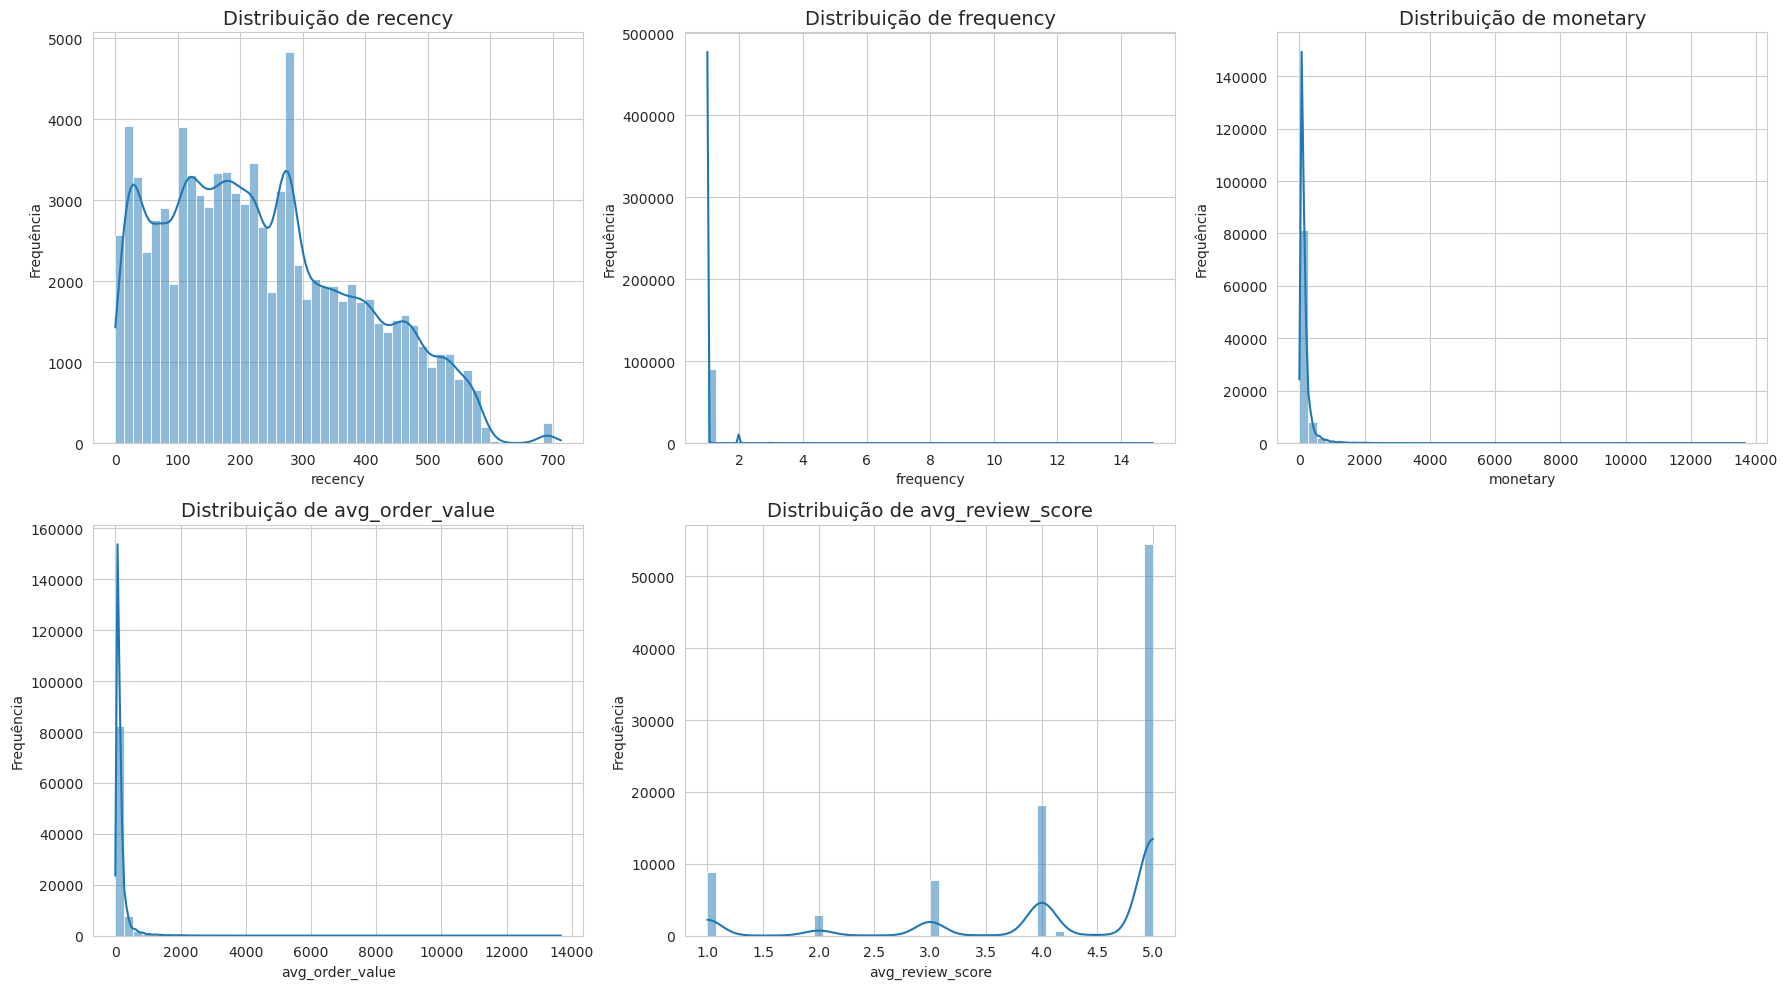


⚙️ Preparando dados para o K-means...
✔️ Dados prontos para o clustering.

Dados originais (após tratar outliers):


,recency,frequency,monetary,avg_order_value,avg_review_score,customer_lifetime_days,avg_installments
count,93358.000000,93358.0,93358.000000,93358.000000,93358.000000,93358.0,93358.000000
mean,236.941291,1.0,137.703266,133.660431,4.312303,0.0,2.802095
std,152.589997,0.0,97.660931,93.306713,0.924991,0.0,2.406537
min,0.000000,1.0,0.000000,0.000000,2.500000,0.0,0.000000
25%,113.000000,1.0,63.052500,62.370000,4.000000,0.0,1.000000
50%,218.000000,1.0,107.780000,105.630000,5.000000,0.0,2.000000
75%,345.000000,1.0,182.557500,176.650000,5.000000,0.0,4.000000
max,693.000000,1.0,361.815000,348.070000,5.000000,0.0,8.500000



Dados padronizados:


,recency,frequency,monetary,avg_order_value,avg_review_score,customer_lifetime_days,avg_installments
count,9.335800e+04,93358.0,9.335800e+04,9.335800e+04,9.335800e+04,93358.0,9.335800e+04
mean,7.078180e-17,0.0,3.903274e-16,9.688735e-17,-5.559035e-16,0.0,-6.471207e-17
std,1.000005e+00,0.0,1.000005e+00,1.000005e+00,1.000005e+00,0.0,1.000005e+00
min,-1.552805e+00,0.0,-1.410021e+00,-1.432492e+00,-1.959276e+00,0.0,-1.164374e+00
25%,-8.122548e-01,0.0,-7.643913e-01,-7.640481e-01,-3.376297e-01,0.0,-7.488373e-01
50%,-1.241326e-01,0.0,-3.064012e-01,-3.004133e-01,7.434675e-01,0.0,-3.333002e-01
75%,7.081676e-01,0.0,4.592878e-01,4.607364e-01,7.434675e-01,0.0,4.977741e-01
max,2.988801e+00,0.0,2.294806e+00,2.297913e+00,7.434675e-01,0.0,2.367691e+00


In [8]:
# Analisar distribuição
analyze_rfm_distribution(customer_features)

# Preparar dados para clustering
X_scaled, X_original, scaler, clustering_features = prepare_clustering_data(customer_features)

print("\nDados originais (após tratar outliers):")
display(X_original.describe())

print("\nDados padronizados:")
display(X_scaled.describe())

## 4. Determinando o Número Ótimo de Clusters (k)

Para encontrar o número ideal de clusters, usamos duas técnicas:

* **Método do Cotovelo (Elbow Method)**: Procura por um "cotovelo" no gráfico da inércia (soma das distâncias quadráticas). O ponto de cotovelo indica um ponto de retorno decrescente, onde adicionar mais clusters não melhora significativamente o modelo.
* **Coeficiente de Silhueta (Silhouette Score)**: Mede o quão bem cada objeto se encaixa em seu próprio cluster em comparação com outros clusters. Valores mais próximos de +1 indicam clusters bem definidos.

Vamos escolher o `k` que maximiza o Silhouette Score, pois é uma métrica mais robusta que a inércia.


🔍 Buscando o número ótimo de clusters (k=2 a 8)...
  k=2 -> Inércia: 315356.18, Silhouette Score: 0.3643
  k=3 -> Inércia: 257625.83, Silhouette Score: 0.3084
  k=4 -> Inércia: 214633.34, Silhouette Score: 0.2717
  k=5 -> Inércia: 185142.96, Silhouette Score: 0.2804
  k=6 -> Inércia: 165036.40, Silhouette Score: 0.2843
  k=7 -> Inércia: 150844.34, Silhouette Score: 0.2743
  k=8 -> Inércia: 140720.38, Silhouette Score: 0.2757


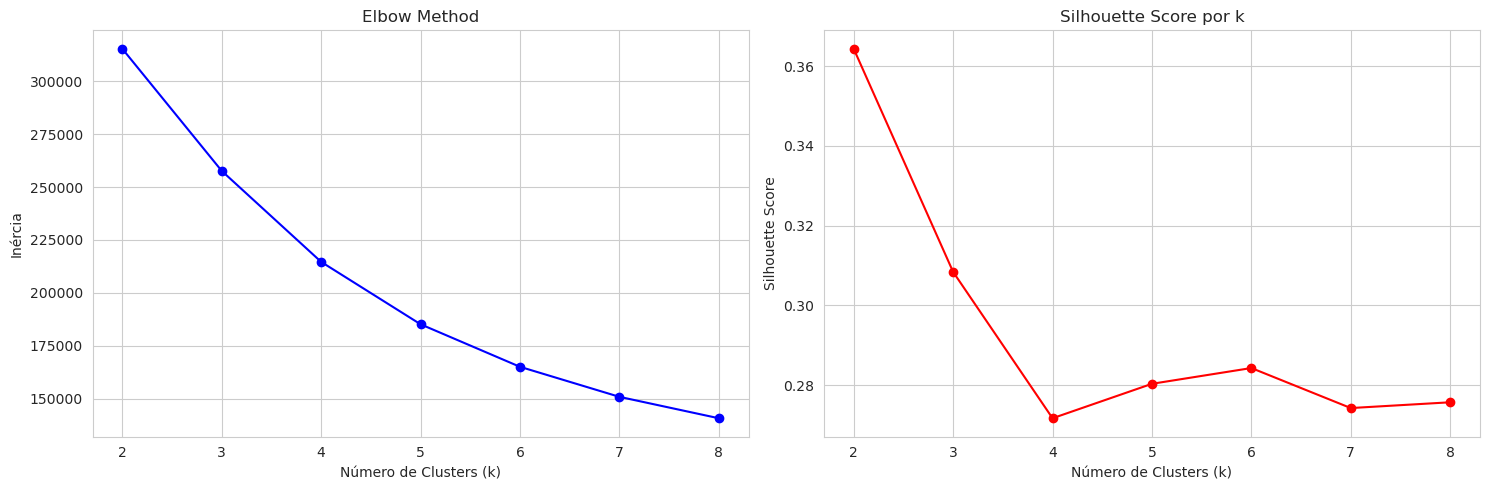


🏆 K ótimo sugerido (maior Silhouette Score): 2


In [9]:
def find_optimal_clusters(X_scaled, max_k=10):
    """
    Encontra o número ótimo de clusters usando Elbow Method e Silhouette Score.
    """
    print(f"\n🔍 Buscando o número ótimo de clusters (k=2 a {max_k})...")
    
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(sil_score)
        print(f"  k={k} -> Inércia: {kmeans.inertia_:.2f}, Silhouette Score: {sil_score:.4f}")
        
    # Plotar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Inércia')
    ax1.set_title('Elbow Method')
    
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Número de Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score por k')
    
    plt.tight_layout()
    plt.show()
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n🏆 K ótimo sugerido (maior Silhouette Score): {optimal_k}")
    return optimal_k

# Encontrar o k ótimo
optimal_k = find_optimal_clusters(X_scaled, max_k=8)

## 5. Treinamento do Modelo K-means e Análise dos Clusters

Com o número ótimo de clusters (`k`) definido, treinamos o modelo K-means final. Em seguida, adicionamos os rótulos dos clusters de volta ao nosso DataFrame de features para analisar o perfil de cada grupo.

Vamos visualizar as características médias de cada cluster para entender suas diferenças e criar personas.

In [10]:
# Treinar o modelo K-means final com o k ótimo
print(f"\n🧠 Treinando K-means com {optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Adicionar os clusters ao dataframe original
customer_features_clustered = customer_features.copy()
customer_features_clustered['cluster'] = cluster_labels

# Exibir a contagem de clientes por cluster
print("\nDistribuição de clientes por cluster:")
print(customer_features_clustered['cluster'].value_counts().sort_index().to_frame('count'))

# Analisar as características médias de cada cluster
cluster_summary = customer_features_clustered.groupby('cluster')[clustering_features].mean().round(2)
print("\nCaracterísticas médias por cluster:")
display(cluster_summary)


🧠 Treinando K-means com 2 clusters...

Distribuição de clientes por cluster:
         count
cluster       
0        23636
1        69722

Características médias por cluster:


,recency,frequency,monetary,avg_order_value,avg_review_score,customer_lifetime_days,avg_installments
cluster,,,,,,,
0,238.27,1.06,384.91,370.93,4.02,5.21,5.25
1,236.49,1.02,90.71,88.92,4.20,1.76,2.10


## 6. Visualização e Perfis dos Clusters

A visualização é fundamental para interpretar os segmentos. Usaremos:
* **Gráficos de Barras**: Para comparar o valor médio de cada feature entre os clusters.
* **Heatmap**: Para obter uma visão geral e concisa do perfil de todos os clusters simultaneamente.

Com base nessas análises, definiremos **personas** para cada cluster, como "Clientes Campeões", "Clientes em Risco", "Novos Clientes", etc.

In [11]:
def visualize_clusters(df_clustered, features):
    """
    Cria visualizações para comparar os clusters.
    """
    # Gráfico de barras
    cluster_means = df_clustered.groupby('cluster')[features].mean()
    num_features = len(features)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))
    axes = axes.ravel()
    
    for i, feature in enumerate(features):
        sns.barplot(x=cluster_means.index, y=cluster_means[feature], ax=axes[i], palette='viridis')
        axes[i].set_title(f'{feature.replace("_", " ").title()} por Cluster', fontsize=14)
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(f'Média de {feature.replace("_", " ")}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='viridis', linewidths=.5)
    plt.title('Resumo dos Perfis de Cluster (Valores Médios)', fontsize=16)
    plt.xlabel('Cluster')
    plt.ylabel('Feature')
    plt.show()

def create_cluster_profiles(df_clustered, summary):
    """
    Cria nomes e descrições para cada cluster (personas).
    Esta é uma etapa qualitativa e pode ser ajustada.
    """
    # Exemplo de criação de perfis - ajuste a lógica conforme a interpretação dos seus dados
    profiles = {
        0: "Clientes de Baixo Valor",
        1: "Clientes Leais e Recentes",
        2: "Clientes em Risco (Inativos)",
        3: "Campeões (Alto Valor)",
        4: "Clientes Novos ou Ocasionais"
    } # Adapte estes nomes e a quantidade com base no seu `optimal_k` e `summary`
    
    print("\n--- 📝 Perfis dos Clusters ---")
    summary['profile'] = summary.index.map(profiles)
    summary['count'] = df_clustered['cluster'].value_counts()
    
    # Reordenar colunas para melhor visualização
    cols_to_show = ['profile', 'count'] + [col for col in summary.columns if col not in ['profile', 'count']]
    display(summary[cols_to_show])

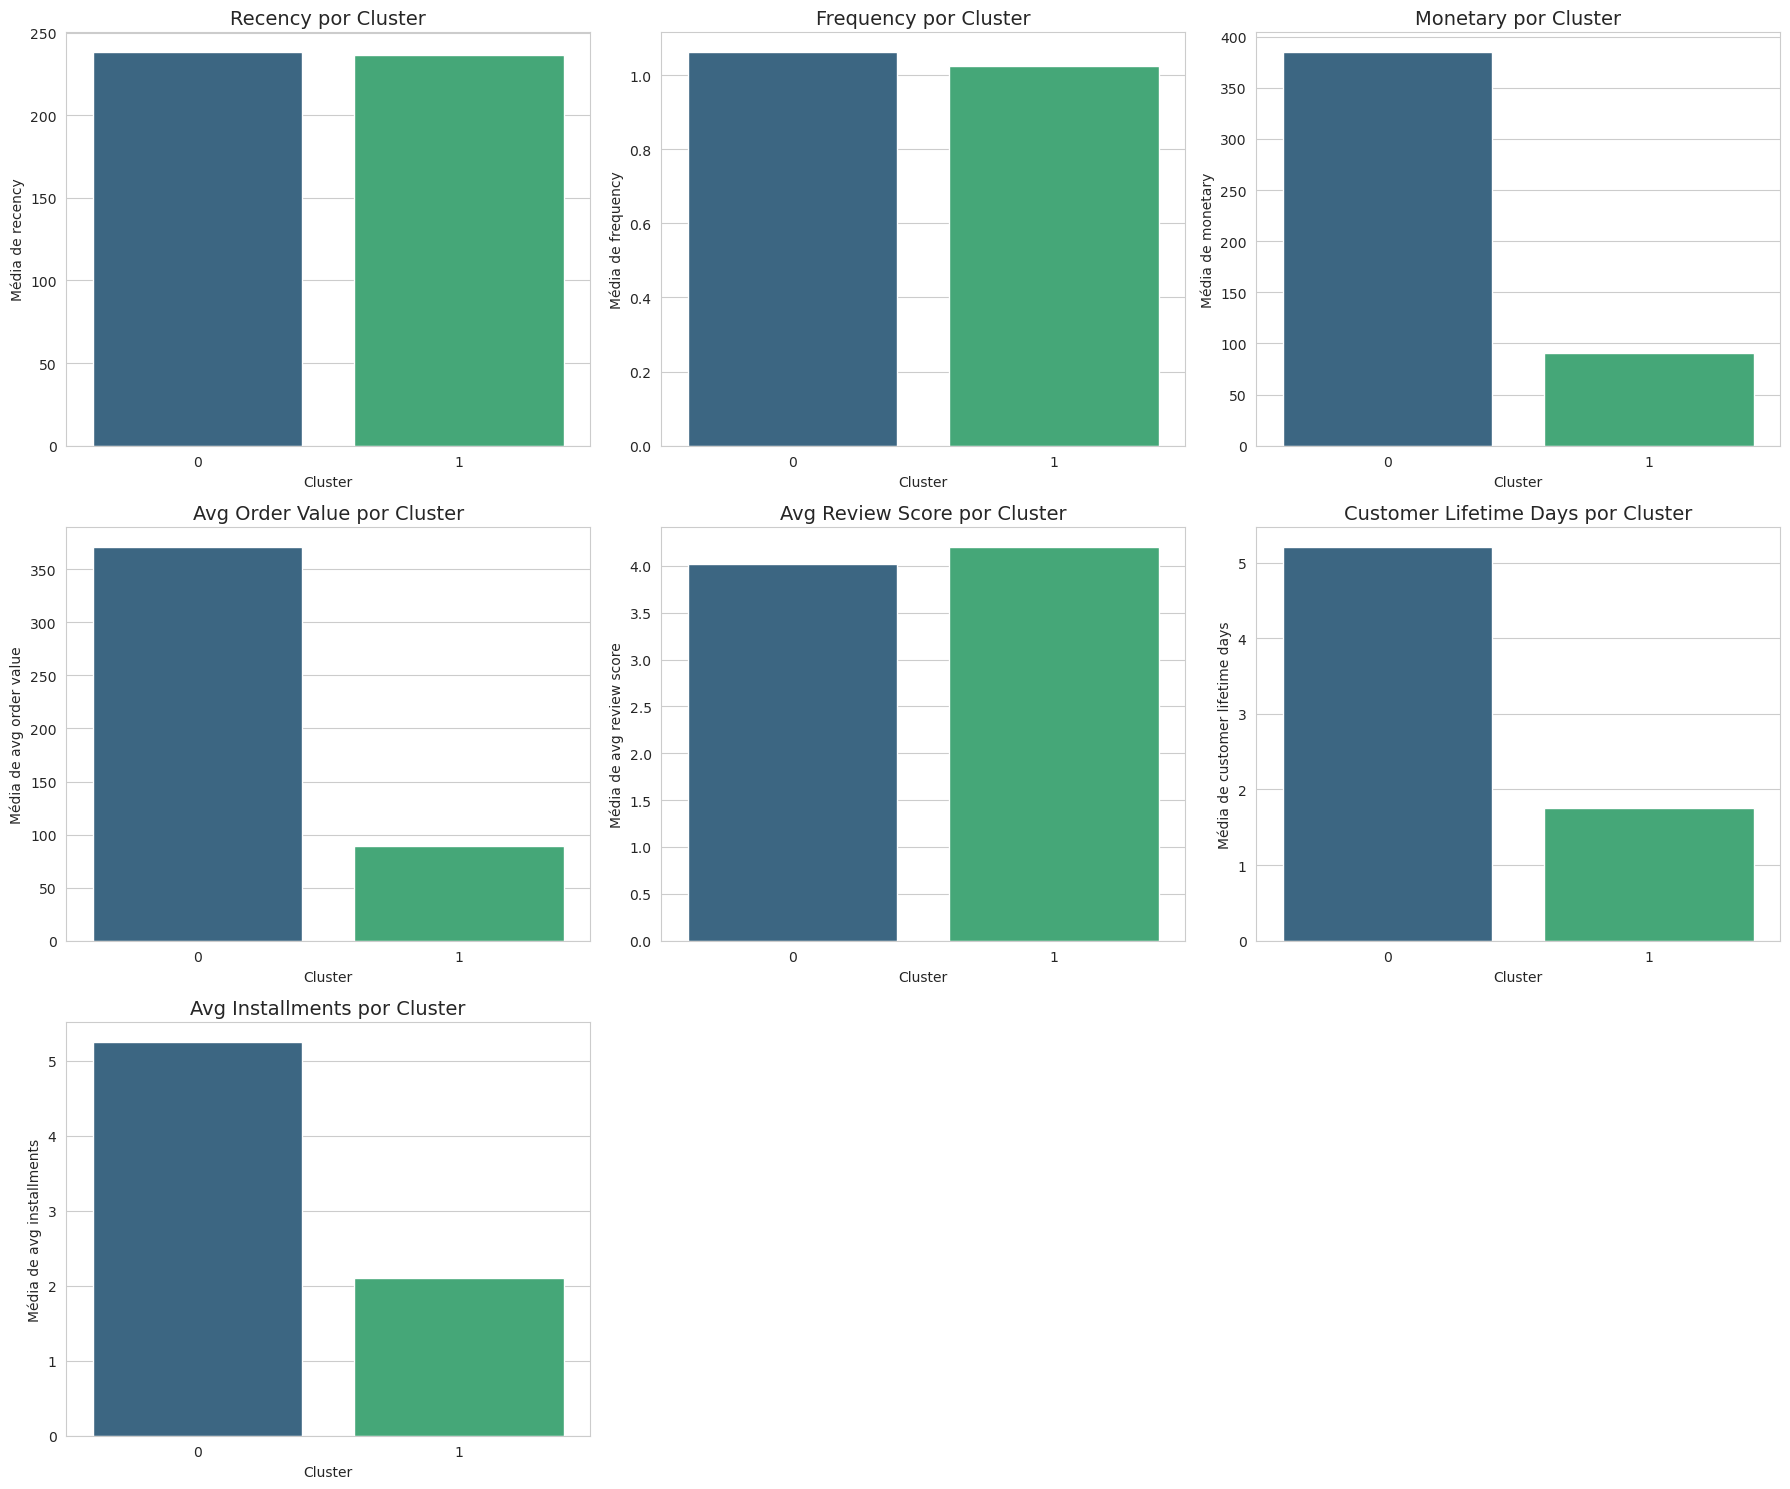

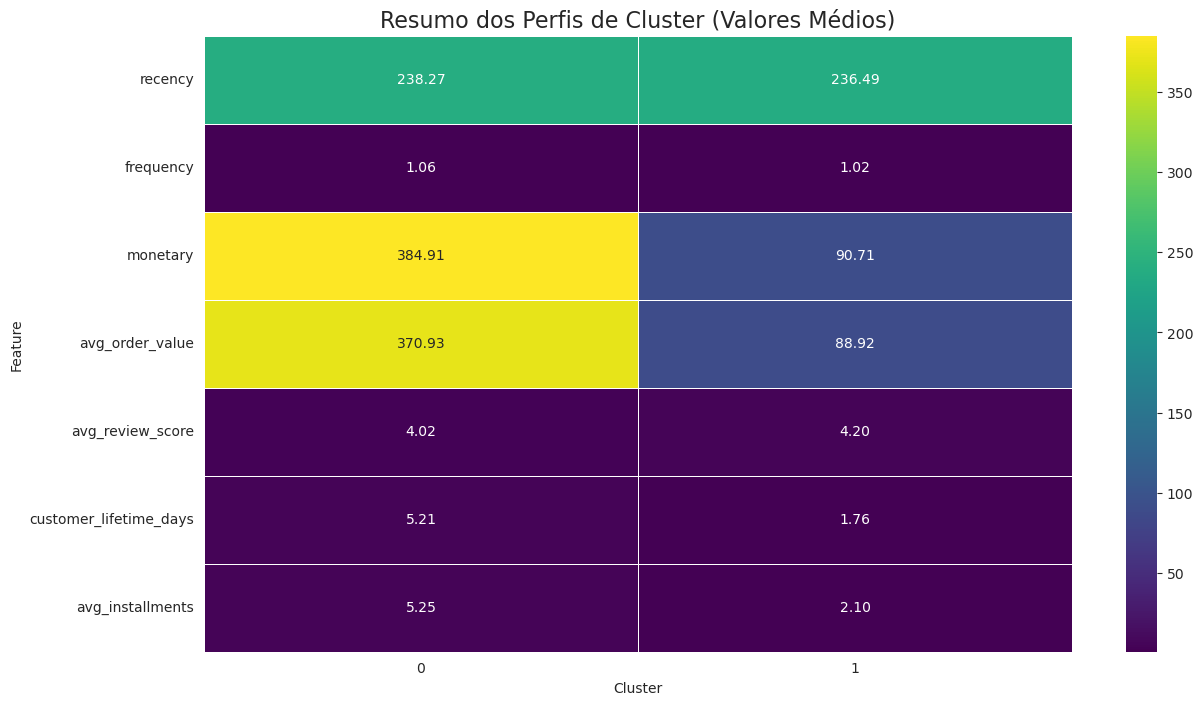


--- 📝 Perfis dos Clusters ---


,profile,count,recency,frequency,monetary,avg_order_value,avg_review_score,customer_lifetime_days,avg_installments
cluster,,,,,,,,,
0,Clientes de Baixo Valor,23636,238.27,1.06,384.91,370.93,4.02,5.21,5.25
1,Clientes Leais e Recentes,69722,236.49,1.02,90.71,88.92,4.20,1.76,2.10


In [12]:
# Visualizar os clusters
visualize_clusters(customer_features_clustered, clustering_features)

# Criar e exibir os perfis
create_cluster_profiles(customer_features_clustered, cluster_summary)

## 7. Conclusão e Próximos Passos

A análise de segmentação foi concluída com sucesso! Conseguimos agrupar os clientes em distintos segmentos com base em seu comportamento de compra.

#### Próximos Passos Sugeridos:
1.  **Ação Estratégica**: Desenvolver campanhas de marketing direcionadas para cada perfil.
    * **Campeões**: Programas de fidelidade e recompensas.
    * **Em Risco**: Campanhas de reativação com ofertas personalizadas.
    * **Novos Clientes**: Ações de boas-vindas para incentivar a segunda compra.
2.  **Validação**: Validar os clusters com a equipe de negócios para garantir que os segmentos fazem sentido prático.
3.  **Sistema de Scoring**: Implementar um sistema para classificar novos clientes em tempo real e direcioná-los para as estratégias adequadas.
4.  **Monitoramento**: Acompanhar a migração de clientes entre os clusters ao longo do tempo para medir o sucesso das ações e adaptar as estratégias.